# 修士論文用
# Transformer モデルを用いてスコアリングを行う．
## データのトリミングを行い，意味のある部分のみを抜き出すアルゴリズムを活用して生成したデータを用いて解析を行う

In [770]:
import os
import sys
import csv
import math
import json
import glob
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import interpolate
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

%matplotlib inline

# sys.path.append(os.path.abspath(".."))
# import scripts.compensate
# import scripts.kinectImg2video
# from scripts.conpemsate_suppresser import *
# from scripts.ground_angle_analysis import ground_shoulder_angle_analyzer
# import scripts.ground_angle_analysis

In [771]:
# Setup seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [772]:
# 日付の追加
df_annotate = pd.read_excel("/Users/kento/kuhp/experiment/for_HCI/annotate_dataset.xlsx")
df_annotate['date'] = pd.to_datetime(df_annotate['date'], format='%Y%m%d%H%M%S')

In [773]:
# DataSetの呼び出し
df_data = pd.read_csv("/Users/kento/kuhp/experiment/bigdata.csv")
df_data['date'] = pd.to_datetime(df_data['date'], format='%Y-%m-%d-%H-%M-%S')

In [774]:
df_annotate

,date,subject_id,task_id,point,body,shoulder,flag_usage
0,2021-12-06 18:56:58,1,1,3,0,0,1
1,2021-12-06 18:56:41,1,1,3,0,0,1
2,2021-12-08 12:25:56,1,1,3,0,0,1
3,2021-12-06 18:56:20,2,1,3,0,0,1
4,2021-12-08 12:26:40,2,1,3,0,0,1
5,2021-12-08 14:14:54,2,1,3,0,0,1
6,2021-12-08 14:15:09,3,1,3,0,0,1
7,2021-12-08 12:27:30,3,1,3,0,0,1
8,2021-12-08 14:15:26,3,1,3,0,0,1
9,2021-12-06 18:58:24,1,1,2A,0,0,1


In [775]:
pd_merged = pd.merge(df_annotate, df_data, on='date', how='inner')
pd_3 = pd_merged[pd_merged['point'] == 3]
pd_2A = pd_merged[pd_merged['point'] == '2A']
pd_2B = pd_merged[pd_merged['point'] == '2B']
pd_2C = pd_merged[pd_merged['point'] == '2C']

In [776]:
dataset = pd.merge(df_annotate, df_data, on='date', how='inner')
dataset.loc[dataset['point'] == '3', 'score'] = 3
dataset.loc[dataset['point'] == '2A', 'score'] = 2
dataset.loc[dataset['point'] == '2B', 'score'] = 1
dataset.loc[dataset['point'] == '2C', 'score'] = 0
# dataset['score'] = dataset['score'].astype(int)

In [777]:
# スコアの付替
pd_3["score"] = 3
pd_2A["score"] = 2
pd_2B["score"] = 1
pd_2C["score"] = 0

/var/folders/yt/fsd0dzhn23z2jcmc2hrkjcn00000gn/T/ipykernel_2289/1814983498.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_3["score"] = 3
/var/folders/yt/fsd0dzhn23z2jcmc2hrkjcn00000gn/T/ipykernel_2289/1814983498.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_2A["score"] = 2
/var/folders/yt/fsd0dzhn23z2jcmc2hrkjcn00000gn/T/ipykernel_2289/1814983498.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

## RElbow2RWrist と Rshoulder2RElbow と Pelvis2RShoulder と Pelvis2Neck の速度を入れてみる 

In [778]:
def add_vector(df, joint1, joint2, word=""):
    df[f"{word}_x_{joint1}2{joint2}"] = df[f"x_{joint1}"].astype('float64') - df[f"x_{joint2}"].astype('float64')
    df[f"{word}_y_{joint1}2{joint2}"] = df[f"y_{joint1}"].astype('float64') - df[f"y_{joint2}"].astype('float64')
    df[f"{word}_z_{joint1}2{joint2}"] = df[f"z_{joint1}"].astype('float64') - df[f"z_{joint2}"].astype('float64')
    return df

dataset = add_vector(dataset, 'RShoulder', "RElbow", 'v')
dataset = add_vector(dataset, 'Pelvis', "RShoulder", 'v')
dataset = add_vector(dataset, 'Pelvis', "Neck", 'v')

In [779]:
df_annotate
l_date = df_annotate['date'].values

In [780]:
def df2Xy(df):
    y = np.array(df["score"].mode()) #一番多いものをscoreとして最後にyとして返す
    y_arr = np.ones(len(df['date'].unique()))
    y_arr = y_arr * y
    l_date_name = np.array(df['date'].unique())
    for k, date in enumerate(l_date_name):
        #一連のデータ，1サンプル
        series = df[df['date'] == l_date_name[k]]
        series = series.drop(columns='point')
        #差分ベクトルを取得
        diff = series.diff().drop(columns='date')
        diff = diff.fillna(0)

        # 間接点同士のベクトルを取得
        df_dataset = add_vector(diff, 'RElbow', "RWrist", 'v')
        df_dataset = add_vector(df_dataset, 'RShoulder', "RElbow", 'v')
        df_dataset = add_vector(df_dataset, 'Pelvis', "RShoulder", 'v')
        df_dataset = add_vector(df_dataset, 'Pelvis', "Neck", 'v')
        arr_data = df_dataset.loc[:, "v_x_RElbow2RWrist":].values
        # print(arr_data.shape)
        for i in range(arr_data.shape[1]):
            tmp_interpolate = interpolate1(arr_data[:, i])
            # print(tmp_interpolate.shape)
            #二次元に拡張
            tmp_interpolate = tmp_interpolate.reshape(tmp_interpolate.shape[0], 1)
            if i == 0:
                x = tmp_interpolate
            else:
                x = np.concatenate([x, tmp_interpolate],1)
        x = x.reshape(1, x.shape[0], x.shape[1])
        if k == 0:
            X = x
            # print(X.shape)
        else:
            X = np.concatenate([X, x], axis=0)
    return (X, y_arr)

In [781]:
def create_Xy(df):
    y = np.array(df["score"].mode()) #一番多いものをscoreとして最後にyとして返す
    y_arr = np.ones(len(df['date'].unique()))
    y_arr = y_arr * y
    l_date_name = np.array(df['date'].unique())
    for k, date in enumerate(l_date_name):
        #一連のデータ，1サンプル
        series = df[df['date'] == l_date_name[k]]
        series = series.drop(columns='point')
        #差分ベクトルを取得
        diff = series.diff().drop(columns='date')
        diff = diff.fillna(0)

        # 間接点同士のベクトルを取得
        df_dataset = add_vector(diff, 'RElbow', "RWrist", 'v')
        df_dataset = add_vector(df_dataset, 'RShoulder', "RElbow", 'v')
        df_dataset = add_vector(df_dataset, 'Pelvis', "RShoulder", 'v')
        df_dataset = add_vector(df_dataset, 'Pelvis', "Neck", 'v')
        arr_data = df_dataset.loc[:, "v_x_RElbow2RWrist":].values
        # print(arr_data.shape)
        for i in range(arr_data.shape[1]):
            tmp_interpolate = interpolate1(arr_data[:, i])
            # print(tmp_interpolate.shape)
            #二次元に拡張
            tmp_interpolate = tmp_interpolate.reshape(tmp_interpolate.shape[0], 1)
            if i == 0:
                x = tmp_interpolate
            else:
                x = np.concatenate([x, tmp_interpolate],1)
        x = x.reshape(1, x.shape[0], x.shape[1])
        if k == 0:
            X = x
            # print(X.shape)
        else:
            X = np.concatenate([X, x], axis=0)
    return (X, y_arr)

In [782]:
(X_3, y_3) = create_Xy(pd_3)
(X_2, y_2) = create_Xy(pd_2A)
(X_1, y_1) = create_Xy(pd_2B)
(X_0, y_0) = create_Xy(pd_2C)

In [783]:
print(y_2)

[2. 2. 2. 2. 2. 2. 2. 2.]


In [784]:
#DataSetの結合
x_train = np.concatenate([X_3, X_2, X_1, X_0])
y_train = np.concatenate([y_3, y_2, y_1, y_0])
y_train = y_train.astype('int64')
x_test = np.concatenate([X_3, X_2, X_1, X_0])
y_test = np.concatenate([y_3, y_2, y_1, y_0])
y_test = y_test.astype('int64')

In [785]:
#ファイル名からスコアを取得して，dfを返す関数 
def read_csv_add_score(filepath, score):
    df = pd.read_csv(filepath, header=None)
    #スコアの取得
    # score = filepath.split("-")[1].split('.')[0]
    df['score'] = score
    return df

def interpolate1(array):
    x_old = np.linspace(0, 1, array.shape[0])
    y_old = array
    
    f = interpolate.interp1d(x_old, y_old)

    x = np.linspace(0, 1, 100)
    y_new = f(x)
    return y_new


def interpolate_df(df):
    y_raw = np.array(df.loc[:, "x_Pelvis":"z_REar"])
    print(i)
    length = len(y_raw)-1

    #rawデータを乗せる0→1のベクトルを作成する
    second_raw = np.linspace(0, 1, length)

    #新しく生成される0→1のベクトル(要素数200)
    second_new = np.linspace(0, 1, 200)

    f = interpolate.interp1d(second_raw, y_raw, kind='cubic')
    y_new = f(second_new)
    l.append(y_new)
    df_new = pd.DataFrame(l).T
    df_new['score'] = df['score'].mode()[0]
    return df_new
    
def extract_joint(df, joint_name):
    # dic = joint_dict()
    # joint_id = dic[joint_name]
    df_ex = df.loc[:, [f"x_{joint_name}", f"y_{joint_name}", f"z_{joint_name}"]]
    df_ex['score'] = df['score'].mode()[0] #scoreを引き継ぐ
    return df_ex

# # 内部メソッド
# def joint_dict():
#     dic = {'Pelvis':2,'SpineNaval':5,'SpineChest':8, 'Neck':11, 'LClavicle':14, 'LShoulder':17, 'LElbow':20, 'LWrist':23, 'LHand':26, 'LHandTip':29, 
#            'LThumb':32, 'RClavicle':35, 'RShoulder':38, 'RElbow':41, 'RWrist':44, 'RHand':47, 'RHandTip':50, 'RThumb':53, 'LHip':56, 'LKnee':59, 
#            'LAnkle':62, 'LFoot':65, 'RHip':68, 'RKnee':71, 'RAnkle':74, 'RFoot':77, 'Head':80, 'Nose':83, 'LEye':86, 'LEar':89, 'REye':92, 'REar':95}
#     return dic

def zscore(x, axis = None):
    xmean = x.mean(axis=axis, keepdims=True)
    xstd  = np.std(x, axis=axis, keepdims=True)
    zscore = (x-xmean)/xstd
    return zscore

In [786]:
def create_pos_dataset(l_filepath, score, joint1_name, joint2_name):
    for filepath in l_filepath:
        df = read_csv_add_score(filepath, score)
        df = interpolate_df(df)
        dataset_joint1 = extract_joint(df, joint1_name)
        dataset_joint2 = extract_joint(df, joint2_name)
        
        #複数のデータ間でscoreのndarray を作成する種
        y_one = np.array([dataset_joint1['score'].mode()[0]], dtype=np.int64)
        if 'y' in locals():
            y = np.concatenate([y, y_one])
        else:
            y = y_one

        #複数のデータ間で X データセットを作成する種
        joint1 = dataset_joint1.iloc[:, 0:3].to_numpy()
        joint1 = np.expand_dims(joint1, axis=0)

        joint2 = dataset_joint2.iloc[:, 0:3].to_numpy()
        joint2 = np.expand_dims(joint2, axis=0)

        X_one = joint1 - joint2
        
        # Xにノルムを追加する
        norm = np.linalg.norm(X_one, axis=2,ord=2)
        norm = norm.reshape((1,-1,1))
        X_one = np.concatenate((X_one, norm), axis=2)

        if 'X' in locals():
            X = np.concatenate([X, X_one])
        else:
            X = X_one
            
    return X, y

In [787]:
print(x_train.shape)

(35, 100, 12)


In [788]:
### 先頭にclassification用のトークンを追加する
score_train = np.zeros((x_train.shape[0], 1 , x_train.shape[2]))
x_train = np.concatenate([score_train, x_train], axis=1)

## PyTorchのdatasetの作成


In [789]:
# この部分がclassificationと異なる
X = torch.tensor(x_train, dtype=torch.float32)
y = torch.tensor(y_train, dtype=torch.int8)

X_val = torch.tensor(x_test, dtype=torch.float32)
y_val = torch.tensor(y_test, dtype=torch.int8)

In [790]:
dataset = torch.utils.data.TensorDataset(X, y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1)

val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=1)

In [791]:
dataloaders_dict = {"train": dataloader, "val": dataloader}

In [792]:
# batch = next(iter(dataloader))
# print(batch[0].max())
# print(batch[0].min())

In [793]:
# import matplotlib.pyplot as plt

# classes = np.unique(y, axis=0)
# print(classes)

# fig = plt.figure(figsize=(10, 15))

# # 各点のプロットを行う
# for i, item in enumerate([0, 10, 20]):
#     c_x_train = x_train[item]
#     # print(f"class is {np.argmax(y_train[item])}")
#     fig.add_subplot(3, 1, i+1)
#     plt.plot(c_x_train[:, :], label=["x", "y", "z"])
#     plt.title(f"score {y_train[item]}")
#     plt.legend(loc="best")
#     plt.grid()

# # 各点のプロットを行う
# # c_x_train = x_train[10]
# # print(f"class is {np.argmax(y_train[11])}")
# # fig.add_subplot(3, 1, 2)
# # plt.plot(c_x_train[:, :], label=["x", "y", "z"])
# # plt.legend(loc="best")
# # plt.grid()


# plt.show()
# plt.close()

In [794]:
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

## Build the model

Our model processes a tensor of shape `(batch size, sequence length, features)`,
where `sequence length` is the number of time steps and `features` is each input
timeseries.

You can replace your classification RNN layers with this one: the
inputs are fully compatible!

We include residual connections, layer normalization, and dropout.
The resulting layer can be stacked multiple times.

The projection layers are implemented through `keras.layers.Conv1D`.

In [795]:
class PositionalEncoder(nn.Module):
    '''入力された単語の位置を示すベクトル情報を付加する'''

    def __init__(self, d_model=12, max_seq_len=256):
        super().__init__()

        self.d_model = d_model  # 単語ベクトルの次元数

        # 単語の順番（pos）と埋め込みベクトルの次元の位置（i）によって一意に定まる値の表をpeとして作成
        pe = torch.zeros(max_seq_len, d_model)

        # GPUが使える場合はGPUへ送る、ここでは省略。実際に学習時には使用する
        # device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        # pe = pe.to(device)

        for pos in range(max_seq_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/d_model)))
                
                # 誤植修正_200510 #79
                # pe[pos, i + 1] = math.cos(pos /
                #                          (10000 ** ((2 * (i + 1))/d_model)))
                pe[pos, i + 1] = math.cos(pos /
                                          (10000 ** ((2 * i)/d_model)))

        # 表peの先頭に、ミニバッチ次元となる次元を足す
        self.pe = pe.unsqueeze(0)

        # 勾配を計算しないようにする
        self.pe.requires_grad = False

    def forward(self, x):
        # 入力xとPositonal Encodingを足し算する
        # xがpeよりも小さいので、大きくする
        ret = math.sqrt(self.d_model)*x + self.pe
        return ret


In [796]:
class Attention(nn.Module):
    def __init__(self, d_model=4):
        super().__init__()

        # SAGANでは1dConvを使用したが、今回は全結合層で特徴量を変換する
        self.q_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)

        # 出力時に使用する全結合層
        self.out = nn.Linear(d_model, d_model)

        # Attentionの大きさ調整の変数
        self.d_k = d_model

    def forward(self, q, k, v, mask):
        # 全結合層で特徴量を変換
        k = self.k_linear(k)
        q = self.q_linear(q)
        v = self.v_linear(v)

        # Attentionの値を計算する
        # 各値を足し算すると大きくなりすぎるので、root(d_k)で割って調整
        weights = torch.matmul(q, k.transpose(1, 2)) / math.sqrt(self.d_k)

        # ここでmaskを計算
        # mask = mask.unsqueeze(1)
        # print(mask)
        # weights = weights.masked_fill(mask == 0, -1e9)

        # softmaxで規格化をする
        normlized_weights = F.softmax(weights, dim=-1)

        # AttentionをValueとかけ算
        output = torch.matmul(normlized_weights, v)

        # 全結合層で特徴量を変換
        output = self.out(output)

        return output, normlized_weights


In [797]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=1024, dropout=0.1):
        '''Attention層から出力を単純に全結合層2つで特徴量を変換するだけのユニットです'''
        super().__init__()

        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        x = self.linear_1(x)
        x = self.dropout(F.relu(x))
        x = self.linear_2(x)
        return x

In [798]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model, dropout=0.1):
        super().__init__()

        # LayerNormalization層
        # https://pytorch.org/docs/stable/nn.html?highlight=layernorm
        self.norm_1 = nn.LayerNorm(d_model)
        self.norm_2 = nn.LayerNorm(d_model)

        # Attention層
        self.attn = Attention(d_model)

        # Attentionのあとの全結合層2つ
        self.ff = FeedForward(d_model)

        # Dropout
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)

    def forward(self, x, mask):
        # 正規化とAttention
        # print(f"input shape is {x.shape}")
        x_normlized = self.norm_1(x)
        output, normlized_weights = self.attn(
            x_normlized, x_normlized, x_normlized, mask)
        
        x2 = x + self.dropout_1(output)

        # 正規化と全結合層
        x_normlized2 = self.norm_2(x2)
        output = x2 + self.dropout_2(self.ff(x_normlized2))
        # print(f"output shape is {output.shape}")

        return output, normlized_weights


In [799]:
class ScoringHead(nn.Module):
    '''Transformer_Blockの出力を使用して，最後にスコアリングを行う'''
    
    def __init__(self, d_model=300, output_dim=1):
        super().__init__()

        # 全結合層
        self.linear = nn.Linear(d_model, output_dim)  # output_dimはポジ・ネガの2つ
        self.output_dim = output_dim

        # 重み初期化処理
        nn.init.normal_(self.linear.weight, std=0.02)
        nn.init.normal_(self.linear.bias, 0)

    def forward(self, x):
        x0 = x[:, 0, :]  # 各ミニバッチの各文の先頭の単語の特徴量（300次元）を取り出す
        weights = self.linear.weight
        out = self.linear(x0)
        
        # print(f"Scoring input shape is {x0.shape}")
        # print(f"Scoring weight shape is {weights.shape}")
        # print(f"Scoring output shape is {out.shape}")

        return out, weights

In [800]:
# class ClassificationHead(nn.Module):
#     '''Transformer_Blockの出力を使用し、最後にクラス分類させる'''

#     def __init__(self, d_model=300, output_dim=1):
#         super().__init__()

#         # 全結合層
#         self.linear = nn.Linear(d_model, output_dim)  # output_dimはポジ・ネガの2つ
#         self.output_dim = output_dim

#         # 重み初期化処理
#         nn.init.normal_(self.linear.weight, std=0.02)
#         nn.init.normal_(self.linear.bias, 0)

#     def forward(self, x):
#         x0 = x[:, 0, :]  # 各ミニバッチの各文の先頭の単語の特徴量（300次元）を取り出す
#         print(f"input shape is {x0.shape}")
#         x1 = self.linear(x0)
#         print(f"weight shape is {self.linear.weight.shape}")
#         print(f"input shape is {x1.shape}")
#         out = F.softmax(x1, dim=-1)

#         return out


In [801]:
# 最終的なTransformerモデルのクラス
'''Scoring を行うモデル'''

class TransformerScoring(nn.Module):
    '''Transformerでクラス分類させる'''

    def __init__(self, d_model=12, max_seq_len=101, output_dim=1):
        super().__init__()

        # モデル構築
        self.net_Positional = PositionalEncoder(d_model=d_model, max_seq_len=max_seq_len)
        self.net_Attention_1 = TransformerBlock(d_model=d_model)
        self.net_Scoring = ScoringHead(output_dim=output_dim, d_model=d_model)

    def forward(self, x, mask):
        x1 = self.net_Positional(x)  # Positon情報を足し算
        x2, normlized_weights_1 = self.net_Attention_1(x1, mask)  # Self-Attentionで特徴量を変換        
        x3, FC_weights = self.net_Scoring(x2)  # 最終出力の0単語目を使用して、分類0-1のスカラーを出力
        
        # print(f"x shape is {x.shape}")
        # print(f"x1 shape is {x1.shape}")
        # print(f"x2 shape is {x2.shape}")
        # print(f"x3 shape is {x3}")
        
        return x3, normlized_weights_1, FC_weights


In [802]:
# # 最終的なTransformerモデルのクラス

# class TransformerClassification(nn.Module):
#     '''Transformerでクラス分類させる'''

#     def __init__(self, d_model=12, max_seq_len=101, output_dim=4):
#         super().__init__()

#         # モデル構築
#         self.net_Positional = PositionalEncoder(d_model=d_model, max_seq_len=max_seq_len)
#         self.net_Attention_1 = TransformerBlock(d_model=d_model)
#         # self.net3_2 = TransformerBlock(d_model=d_model)
#         self.net_Classification = ClassificationHead(output_dim=output_dim, d_model=d_model)

#     def forward(self, x, mask):
#         x1 = self.net_Positional(x)  # Positon情報を足し算
#         x2, normlized_weights_1 = self.net_Attention_1(x1, mask)  # Self-Attentionで特徴量を変換
        
#         # x3_2, normlized_weights_2 = self.net3_2(x3_1, mask)  # Self-Attentionで特徴量を変換
        
#         x3 = self.net_Classification(x2)  # 最終出力の0単語目を使用して、分類0-1のスカラーを出力
        
#         return x3, normlized_weights_1


## Train and evaluate

In [803]:
# 動作確認
# ミニバッチの用意
batch = next(iter(dataloader))

# モデル構築
net = TransformerScoring(
    d_model=12, max_seq_len=101, output_dim=1)

# 入出力
x = batch[0]
input_mask = (x != input_pad)
out, normlized_weights_1, fc_weight = net(x, input_mask)

print("出力のテンソルサイズ：", out)
# print("出力テンソルのsigmoid：", F.softmax(out, dim=1))


出力のテンソルサイズ： tensor([[-0.8432]], grad_fn=<AddmmBackward0>)


The main part of our model is now complete. We can stack multiple of those
`transformer_encoder` blocks and we can also proceed to add the final
Multi-Layer Perceptron classification head. Apart from a stack of `Dense`
layers, we need to reduce the output tensor of the `TransformerEncoder` part of
our model down to a vector of features for each data point in the current
batch. A common way to achieve this is to use a pooling layer. For
this example, a `GlobalAveragePooling1D` layer is sufficient.

In [804]:
# ネットワークの初期化を定義
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        # Liner層の初期化
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.0)

# 訓練モードに設定
net.train()

# TransformerBlockモジュールを初期化実行
net.net_Attention_1.apply(weights_init)
# net.net3_2.apply(weights_init)

print('ネットワーク設定完了')

ネットワーク設定完了


In [805]:
# 損失関数の設定
# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
# nn.LogSoftmax()を計算してからnn.NLLLoss(negative log likelihood loss)を計算

# 最適化手法の設定
learning_rate = 1e-4
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [806]:
# モデルを学習させる関数を作成
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)
    print('-----start-------')
    # ネットワークをGPUへ
    net.to(device)

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # epochのループ
    for epoch in range(num_epochs):
        # epochごとの訓練と検証のループ
        for phase in ['train']:
        # for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
            else:
                net.eval()   # モデルを検証モードに

            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数

            # データローダーからミニバッチを取り出すループ
            for batch in (dataloaders_dict[phase]):
                # batchはTextとLableの辞書オブジェクト

                # GPUが使えるならGPUにデータを送る
                inputs = batch[0].to(device)  # 文章
                labels = batch[1].to(device)  # ラベル

                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):

                    # mask作成
                    input_pad = 1  # 単語のIDにおいて、'<pad>': 1 なので
                    input_mask = (inputs != input_pad)

                    # Transformerに入力
                    outputs, _, __ = net(inputs, input_mask)
                    # print(f"outputs shape is {outputs.dtype}, label shape is {labels.float()}")
                    # print(f"outputs is {outputs[0]}")
                    # print(f"labels is {labels.float()}")
                    loss = criterion(outputs[0], labels.float())  # 損失を計算
                    # print(f"loss is {loss}")

                    preds = torch.round(outputs)  # ラベルを予測

                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # 結果の計算
                    epoch_loss += loss.item() * inputs.size(0)  # lossの合計を更新
                    # accuracyの計算
                    # print(preds[0].int())
                    # print(labels.data)
                    epoch_corrects += torch.sum(preds[0].int() == labels.data)

            # epochごとのlossと正解率
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloaders_dict[phase].dataset)

            print('Epoch {}/{} | {:^5} |  Loss: {:.4f} Acc: {:.4f}'.format(epoch+1, num_epochs,
                                                                           phase, epoch_loss, epoch_acc))

    return net


In [808]:
# 学習・検証を実行する 15分ほどかかります
num_epochs = 150
net_trained = train_model(net, dataloaders_dict,
                          criterion, optimizer, num_epochs=num_epochs)

使用デバイス： cpu
-----start-------
Epoch 1/150 | train |  Loss: 0.9594 Acc: 0.3429
Epoch 2/150 | train |  Loss: 0.9952 Acc: 0.2857
Epoch 3/150 | train |  Loss: 0.9320 Acc: 0.2857
Epoch 4/150 | train |  Loss: 1.1261 Acc: 0.4286
Epoch 5/150 | train |  Loss: 0.8961 Acc: 0.4286
Epoch 6/150 | train |  Loss: 0.7855 Acc: 0.4000
Epoch 7/150 | train |  Loss: 0.7964 Acc: 0.3143
Epoch 8/150 | train |  Loss: 0.8054 Acc: 0.4286
Epoch 9/150 | train |  Loss: 0.7243 Acc: 0.3429
Epoch 10/150 | train |  Loss: 0.8530 Acc: 0.4286
Epoch 11/150 | train |  Loss: 0.6550 Acc: 0.4286
Epoch 12/150 | train |  Loss: 0.9092 Acc: 0.4000
Epoch 13/150 | train |  Loss: 0.7937 Acc: 0.3429
Epoch 14/150 | train |  Loss: 0.6734 Acc: 0.3429
Epoch 15/150 | train |  Loss: 0.7201 Acc: 0.4000
Epoch 16/150 | train |  Loss: 0.8046 Acc: 0.3714
Epoch 17/150 | train |  Loss: 0.5855 Acc: 0.4571
Epoch 18/150 | train |  Loss: 0.7995 Acc: 0.3714
Epoch 19/150 | train |  Loss: 0.6561 Acc: 0.4286
Epoch 20/150 | train |  Loss: 0.8911 Acc: 0.3714

# 精度の確認

In [828]:
print(dataset[:][0].shape[0])

35


In [836]:
batch = next(iter(dataloader))
print(batch[0])

tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 9.2809, 11.8534,  0.0871,  ...,  0.2215, -2.8174,  6.0727],
         ...,
         [-4.2335,  3.7322,  0.7276,  ...,  1.8061,  0.1044,  1.5744],
         [-4.4553,  3.4119,  0.0133,  ...,  2.0784, -0.7955,  2.0905],
         [-4.7545,  3.3176, -0.6290,  ...,  2.2053, -1.7590,  2.5436]]])


In [839]:
test_dataloader = torch.utils.data.DataLoader(dataset, batch_size=dataset[:][0].shape[0])


batch = next(iter(test_dataloader))
inputs = batch[0].to(device)  # 文章

# mask作成
input_pad = 1  # 単語のIDにおいて、'<pad>': 1 なので
input_mask = (inputs != input_pad)

# Transformerに入力
outputs, _, __ = net_trained(inputs, input_mask)

In [893]:
print(np.array(outputs[:, 0]))
print(np.array(batch[1]))

[ 2.909889    2.4394362   2.722674    3.5028772   3.164179    2.644692
  2.277336    2.921031    3.0861044   1.9221671   2.6151156   1.5316896
  1.83019     1.3610053   2.0275881   2.0546308   1.7874298   1.0868149
  1.0061114   1.3471127   0.33213925  1.8020635   0.791824    0.9860859
  1.798842    0.8050499   0.53445005  0.73453283 -0.08197969  0.2702129
  0.4352759   0.02622473  0.28165293  1.0443665   0.06181079]
[3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]


# SaveModel

In [897]:
# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net_trained.eval()   # モデルを検証モードに
net_trained.to(device)

epoch_corrects = 0  # epochの正解数

test_dataloader = torch.utils.data.DataLoader(dataset, batch_size=60)

for batch in (test_dataloader):  # testデータのDataLoader
    # batchはTextとLableの辞書オブジェクト
    
    # GPUが使えるならGPUにデータを送る
    inputs = batch[0].to(device)  # 文章
    labels = batch[1].to(device)  # ラベル

    # 順伝搬（forward）計算
    with torch.set_grad_enabled(False):

        # mask作成
        input_pad = 1  # 単語のIDにおいて、'<pad>': 1 なので
        input_mask = (inputs != input_pad)

        # Transformerに入力
        outputs, attn_weights1, fc_weight = net_trained(inputs, input_mask)
        preds = torch.round(outputs)  # ラベルを予測

        # 結果の計算
        # 正解数の合計を更新
        # print(preds[:, 0].int() == labels.data)
        # print(preds[:, 0].int())
        # print(labels.data)
        # print(torch.sum(preds.int() == labels.data))
        epoch_corrects += torch.sum(preds[:, 0].int() == labels.data)

# 正解率
epoch_acc = epoch_corrects.double() / len(test_dataloader.dataset)

print('テストデータ{}個での正解率：{:.4f}'.format(len(dataloader.dataset),epoch_acc))

テストデータ35個での正解率：0.6857


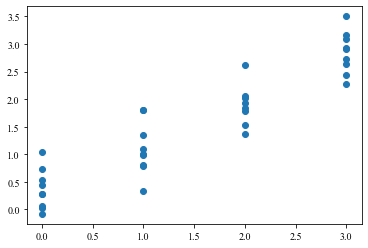

In [896]:
# サンプルごとに代償動作の度合いをセッティングしてみる
preds = np.array(outputs[:, 0])
ans = np.array(batch[1])
plt.scatter(ans, preds)

In [898]:
# import seaborn as sns
# from sklearn.metrics import confusion_matrix


# preds_heat = np.array(preds)
# trues_heat = np.array(torch.argmax(labels.data, dim=1))
# # preds_heat[0] = "3A"
# print(preds_heat)
# print(trues_heat)

# heat = confusion_matrix(trues_heat, preds_heat)
# print(heat)

# plt.rcParams["font.family"] = "Times New Roman"   # 使用するフォント
# plt.rcParams["font.size"] = 20        

# fig, ax = plt.subplots(figsize=(8, 6))
# xtics = ["3", "2A", "2B", "2C"]
# ytics = ["3", "2A", "2B", "2C"]
# # Set the palette using the name of a palette:
# sns.heatmap(heat, annot=True, xticklabels=xtics, yticklabels=ytics, cmap="Blues", cbar=False)
# #*以下2行がポイント*  X,Y軸ラベルを追加
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# #グラフをはみ出さないようにして画面に出力
# plt.tight_layout()
# fig.savefig("nn-heatmap.pdf")
# plt.show()

In [899]:
print(X.shape)
print(np.array(X[0, 1:, 0]).shape)

torch.Size([35, 101, 12])
(100,)


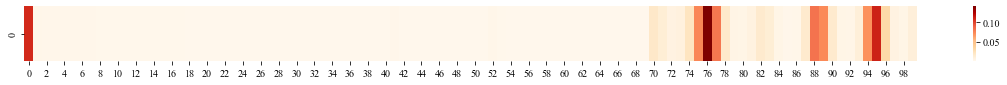

In [900]:
extract_weight = np.array(attn_weights1[15, 0, 1:]).reshape(1, -1)

fig, ax = plt.subplots(figsize=(20, 1))
# Set the palette using the name of a palette:
sns.heatmap(extract_weight, cmap='OrRd')
plt.show()

(100,)


/Users/kento/miniforge3/envs/torch/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


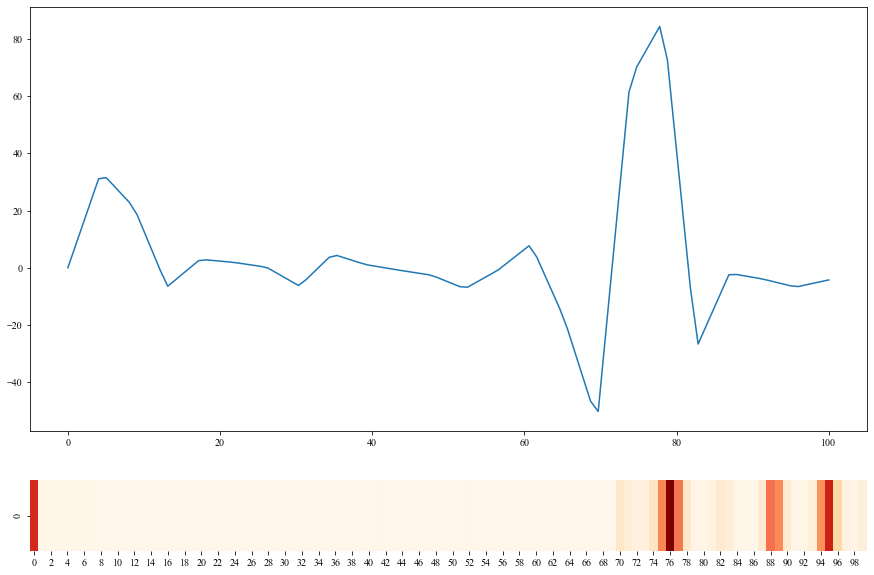

In [901]:
from matplotlib import gridspec

extract_data = np.array(X[19, 1:, 1]).flatten()
print(extract_data.shape)


time = np.linspace(0, 100, 100)
fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [6, 1]}, figsize=(15,10))
# Set the palette using the name of a palette:
sns.lineplot(time, extract_data, ax=ax[0])
sns.heatmap(extract_weight, cmap='OrRd', cbar=False, ax=ax[1])

plt.show()

(35, 101)
(35, 101)


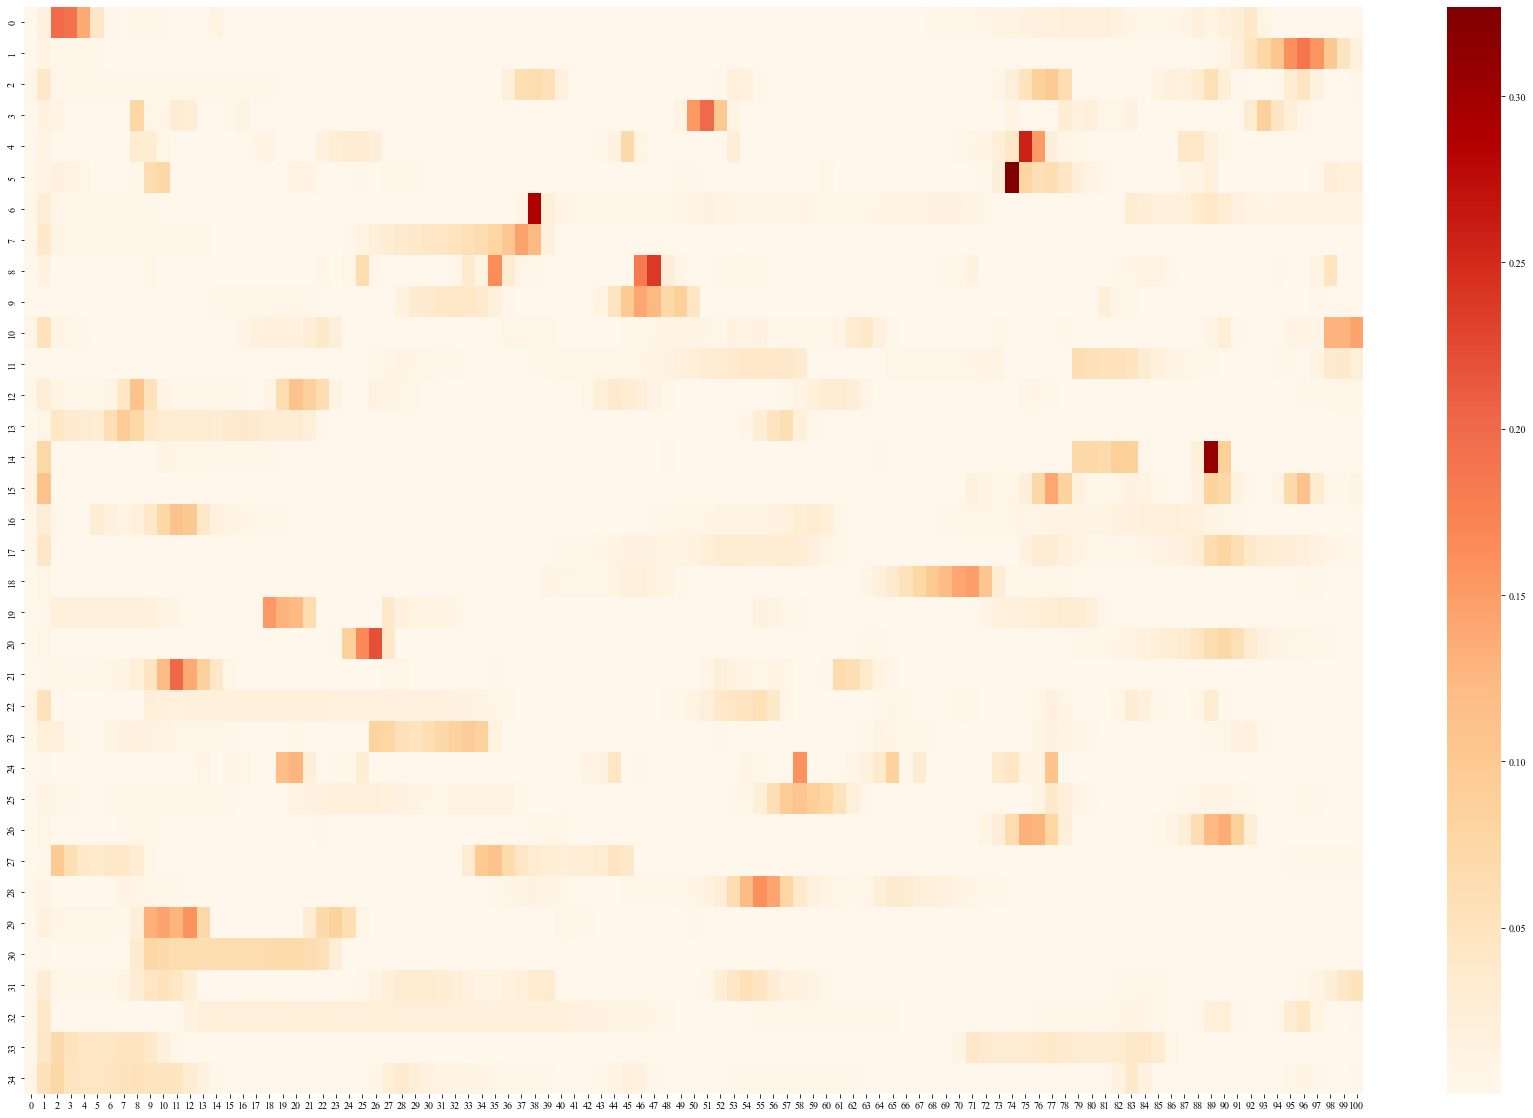

In [902]:
import seaborn as sns

data = np.array(attn_weights1[:, 0, :])
print(data.shape)
data = data.reshape(attn_weights1.shape[0], -1)

# print(outputs)
print(data.shape)

fig, ax = plt.subplots(figsize=(30, 20))
# Set the palette using the name of a palette:
sns.heatmap(data, cmap='OrRd')
plt.show()

# Extract model weights

In [ ]:
from keras.models import Model
layer_name = 'multi_head_attention_10'
hidden_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

In [ ]:
hidden_output = hidden_layer_model.predict(x_train)
hidden_output.shape

In [ ]:
weights = model.get_layer(layer_name).get_weights()
# print(weights)
print(type(weights))
print(len(weights))
print(weights[0].shape)
print(weights[0][0].shape)

In [ ]:
print(hidden_output[0, :, :])

## Conclusions

In about 110-120 epochs (25s each on Colab), the model reaches a training
accuracy of ~0.95, validation accuracy of ~84 and a testing
accuracy of ~85, without hyperparameter tuning. And that is for a model
with less than 100k parameters. Of course, parameter count and accuracy could be
improved by a hyperparameter search and a more sophisticated learning rate
schedule, or a different optimizer.

In [294]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

pred = model.predict(x_train)
# print(pred)
# print(y_test)
test_seed = np.argmax(y_train, axis=1)
onehot_pred_seed = np.argmax(pred, axis=1)
onehot_pred = np.zeros((len(y_train), n_classes))

for i in range(len(y_train)):
    onehot_pred[i, onehot_pred_seed[i]] = 1
print(onehot_pred)

plt.figure()
# sns.heatmap(pred)

labels = sorted(list(set(test_seed)))
c_mtx = confusion_matrix(test_seed, onehot_pred_seed)
print(c_mtx)
df_cmx = pd.DataFrame(c_mtx, index=labels, columns=labels)

plt.figure(figsize = (10,7))
sns.heatmap(df_cmx, annot=True, cmap='Blues')
plt.show()

NameError: name 'model' is not defined

In [ ]:


pred = model.predict(x_test)
mask = pred[:, 0] > 0.7
print(mask)
prediction = np.ones(len(pred))
prediction[mask] = int(0)
print(prediction)
print(y_test)

# confusion_matrix(y_test, prediction)

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, pred[:, 1])
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()
# plt.savefig('data/dst/sklearn_roc_curve.png')
